<a href="https://colab.research.google.com/github/arschallwig/351_PDEOPNet/blob/main/code/Fourier_PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.fft import fft2, ifft2

#we want higher precision here to mimick a numerical solver
tf.keras.backend.set_floatx('float64')

import matplotlib.pyplot as plt
import matplotlib as mpl


### Setting up boundary and colocation points

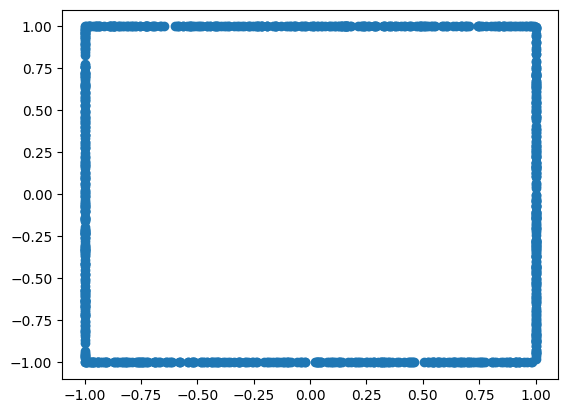

In [ ]:
# let's say want 1000 boundary points on unit plate --> 500 L/R edges, 500 T/B edges
lrx = np.random.choice([-1, 1], 500)
lry = np.random.uniform(low=-1, high=1, size=500)

tbx = np.random.uniform(low=-1, high=1, size=500)
tby = np.random.choice([-1, 1], 500)


LR = np.column_stack((lrx, lry))
TB = np.column_stack((tbx, tby))
boundary = np.vstack((LR, TB))
boundary
plt.scatter(boundary[:,0].T, boundary[:,1].T)

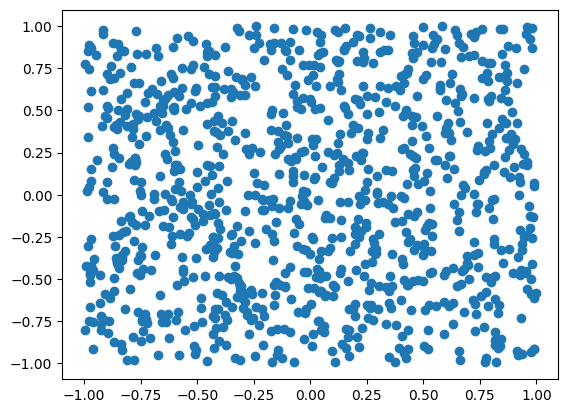

In [ ]:
colloc = np.column_stack((np.random.uniform(low=-1, high=1, size=1000),
                         np.random.uniform(low=-1, high=1, size=1000)))

plt.scatter(colloc[:,0].T, colloc[:, 1].T)

In [ ]:
# add temp values: uniform plate except at top edge
plate_temps = np.full(shape=(1000, 1), fill_value=-1)
colloc = np.hstack((colloc, plate_temps))
colloc.shape

(1000, 3)

In [ ]:
# LRB temp values should all be same
boundary_temps = np.where(boundary[:, 1] > -1, -1, 1)
boundary_temps = boundary_temps.reshape(1000, 1)
boundary = np.hstack((boundary, boundary_temps))

(-1.1, 1.1, -1.1, 1.1)

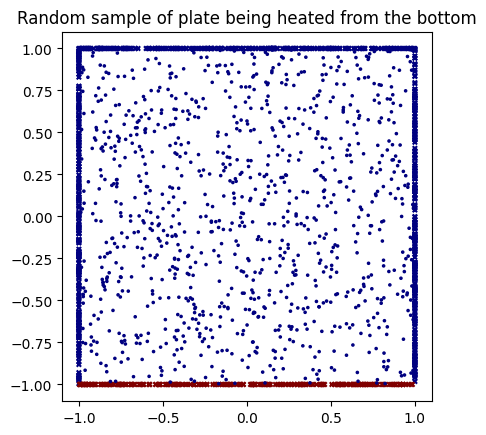

In [ ]:
plt.scatter(boundary[:, 0].T, boundary[:, 1].T, s=10, c=boundary[:, 2].T, cmap='jet', marker='x')
plt.scatter(colloc[:, 0].T, colloc[:, 1].T, s=10, c=colloc[:, 2].T, cmap='jet', marker='.')
plt.title('Random sample of plate being heated from the bottom')
plt.axis('square')

Define Fourier Layer

In [6]:
class Fourier(tf.keras.layers.Layer):
  def __init__(self, units=32, input_dim=32):
    super().__init__()
    self.w = self.add_weight()
    self.r = self.add_weight()

  def call(self, inputs):
    fourier = fft2(inputs)

    return

### Defining the Model

In [ ]:
# define the model
input = tf.keras.layers.Input(shape=2)
hidden = [tf.keras.layers.Dense(20, 'tanh', activity_regularizer=None)(input)]
for i in range(9): #num hidden - 1 for one above
  hidden.append(tf.keras.layers.Dense(20, 'tanh', activity_regularizer=None)(hidden[-1]))

output = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
model = tf.keras.Model(input, output, name='PINN')

In [ ]:
@tf.function
def u(x, y):
  return model(tf.concat([x, y], axis=1))

# define loss on boundary
@tf.function
def Ldata(y, y_pred):
  return tf.reduce_mean(tf.square(y - y_pred))

# define physics-informed losses
@tf.function
def LPDE(x, y, k):
  u_out = u(x, y)

  ux = tf.gradients(u_out, x)[0]
  uxx = tf.gradients(ux, x)[0]

  uy = tf.gradients(u_out, y)[0]
  uyy = tf.gradients(uy, y)[0]

  return tf.reduce_mean(tf.square(uxx + uyy + k**2 * u_out))

In [ ]:
model.summary()

Model: "PINN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_20 (Dense)            (None, 20)                60        
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 20)                420       
                                                                 
 dense_25 (Dense)            (None, 20)                420    

### Model Training

In [ ]:
# prep data from before

convert = lambda x: tf.convert_to_tensor(np.expand_dims(x, axis=1))
x_b, y_b, t_b, x_c, y_c = map(convert, [boundary[:, 0], boundary[:, 1], boundary[:, 2], colloc[:, 0], colloc[:, 1]])

    0, 8.820
  200, 0.834
  400, 0.664
  600, 0.389
  800, 0.306
  999, 0.275

computation time: 56.219



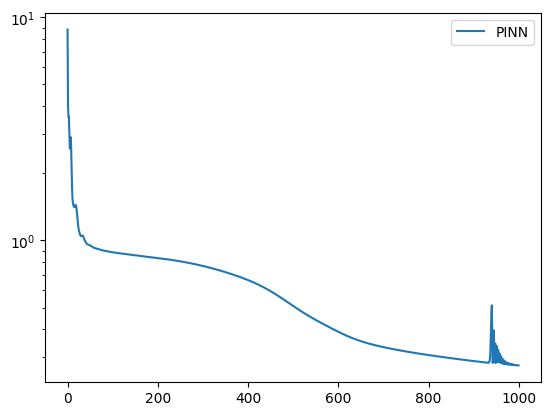

In [ ]:
import time

loss = 0
epochs = 1000
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T = u(x_b, y_b)
        pinn_loss = LPDE(x_c, y_c, 2)
        data_loss = Ldata(t_b, T)
        combined_loss = data_loss + pinn_loss
    g = tape.gradient(combined_loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, combined_loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {combined_loss.numpy():.3f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

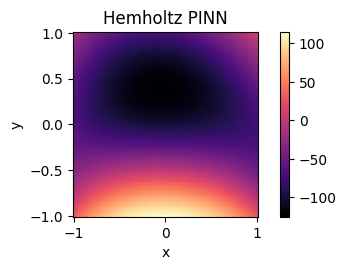

In [ ]:
n = 100
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Hemholtz PINN")
plt.tight_layout()
plt.axis("square")